In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import Tensor, optim, cuda
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset
import torch.nn as nn
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import Tensor, optim, cuda
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import csv
import os
from tensorboardX import SummaryWriter
from sklearn.metrics import roc_auc_score, accuracy_score

from tqdm import tqdm_notebook as tqdm

from data.datasets import DeClareDataset
from model.deClare import DeClareModel
from metrics.evaluation import DeClareEvaluation

In [2]:
torch.cuda.is_available()

False

# Load Datasets

In [3]:
SNOPES_LOC = "./Datasets/Snopes/snopes.tsv"
#consists of rumors analyzed on the Snopes website along with their credibility labels (true or false), 
#sets of reporting articles, and their respective web sources

POLITIFACT_LOC = "./Datasets/PolitiFact/politifact.tsv"

glove_data_file = "./Glove/glove.6B.100d.txt"

In [6]:
snopes = DeClareDataset(SNOPES_LOC, glove_data_file)

Successfully read news data from ./Datasets/Snopes/snopes.tsv
Number of articles = 29242
Number of claims = 4341
Building vocabulary. This could take a while..


/Users/johnjoy/information_systems/DeClare/data/datasets.py:128: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return self.glove_df.loc[w].as_matrix()


Finished building vocabulary


In [7]:
snopes.news_df.head()

,Credibility,Claim_Source,Claim,Article,Article_Source
0,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,there are several holidays throughout that tim...,www.godlikeproductions.com
1,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,defenses against same photographs show images ...,www.sjpba.net
2,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,the best that life could think out we extended...,www.englisher.net
3,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,this entry november 19 2006 published 9 years ...,rss2.com
4,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,place he will not do either said snape the ord...,www.englisher.net


## Preliminary Analysis

In [12]:
snopes_df = snopes.news_df

In [23]:
snopes_df[snopes_df['Credibility'] == 'false']['Article_Source'].value_counts()[:60]

hoax.trendolizer.com                  378
www.sjpba.net                         264
camelopardid2.rssing.com              224
en.wikipedia.org                      198
www.truthorfiction.com                156
www.reddit.com                        146
answers.yahoo.com                     140
www.freerepublic.com                  131
www.hoax-slayer.com                   131
www.democraticunderground.com         125
regator.com                           107
www.dailymail.co.uk                   104
urbanlegends.about.com                 98
groups.yahoo.com                       80
www.huffingtonpost.com                 77
nuzzel.com                             76
www.godlikeproductions.com             75
www.inquisitr.com                      74
www.jefferly.com                       69
www.topix.com                          69
plus.google.com                        69
beforeitsnews.com                      67
www.sodahead.com                       66
www.quora.com                     

In [24]:
snopes.news_df.head()

,Credibility,Claim_Source,Claim,Article,Article_Source
0,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,there are several holidays throughout that tim...,www.godlikeproductions.com
1,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,defenses against same photographs show images ...,www.sjpba.net
2,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,the best that life could think out we extended...,www.englisher.net
3,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,this entry november 19 2006 published 9 years ...,rss2.com
4,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,place he will not do either said snape the ord...,www.englisher.net


In [25]:
batch_size = 64
nb_lstm_units = 64
random_seed = 42

val_split = 0.1
test_split = 0.1
shuffle_dataset = False

In [26]:
# Creating data indices for training and validation splits:
dataset_size = len(snopes)
indices = list(range(dataset_size))

val_split = int(np.floor(val_split * dataset_size))
test_split = val_split + int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[test_split:], indices[:val_split], indices[val_split:test_split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [27]:
train_dataloader = DataLoader(snopes, batch_size, sampler=train_sampler)
val_dataloader = DataLoader(snopes, len(val_indices), sampler=val_sampler)
test_dataloader = DataLoader(snopes, len(test_indices), sampler=test_sampler)

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
declare = DeClareModel(snopes.initial_embeddings, snopes.claim_source_vocab_size, 
                       snopes.article_source_vocab_size, nb_lstm_units, device)

declare.to(device)

DeClareModel(
  (word_embeddings): Embedding(56755, 100)
  (claim_source_embeddings): Embedding(4342, 4)
  (article_source_embeddings): Embedding(12237, 8)
  (attention_dense): Linear(in_features=200, out_features=1, bias=True)
  (attention_dropout): Dropout(p=0.5, inplace=False)
  (dense_1): Linear(in_features=140, out_features=64, bias=True)
  (dense_1_dropout): Dropout(p=0.5, inplace=False)
  (dense_2): Linear(in_features=64, out_features=64, bias=True)
  (dense_2_dropout): Dropout(p=0.5, inplace=False)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (biLSTM): LSTM(100, 64, batch_first=True, bidirectional=True)
)

In [30]:
optimizer = optim.Adam(declare.parameters(), lr=0.005)
BCEloss = nn.BCELoss()

In [41]:
for params in declare.named_parameters():
    print(params[0])

word_embeddings.weight
claim_source_embeddings.weight
article_source_embeddings.weight
attention_dense.weight
attention_dense.bias
dense_1.weight
dense_1.bias
dense_2.weight
dense_2.bias
output_layer.weight
output_layer.bias
biLSTM.weight_ih_l0
biLSTM.weight_hh_l0
biLSTM.bias_ih_l0
biLSTM.bias_hh_l0
biLSTM.weight_ih_l0_reverse
biLSTM.weight_hh_l0_reverse
biLSTM.bias_ih_l0_reverse
biLSTM.bias_hh_l0_reverse


In [31]:
losses = {}
num_epochs = 20
reg_lambda = 0.0002

writer = SummaryWriter()

for epoch in range(num_epochs):
    losses[epoch] = []
    for data_sample in tqdm(train_dataloader):
         
        declare.zero_grad()
        idx = np.argsort(-data_sample[3])

        for i in range(len(data_sample)):
            data_sample[i] = data_sample[i][idx].to(device)

        out = declare(data_sample[0], data_sample[1], data_sample[2], data_sample[3], data_sample[4], data_sample[5])
        loss = BCEloss(out, data_sample[6].float())

        l2_reg = None
        for param in declare.named_parameters():
            if 'dense' in param[0] and 'weight' in param[0]:
                if l2_reg is None:
                    l2_reg = param[1].norm(2)
                else:
                    l2_reg = l2_reg + param[1].norm(2)

        total_loss = loss + reg_lambda*l2_reg

        total_loss.backward()
        optimizer.step()

        writer.add_scalar('total loss', total_loss, epoch)
        writer.add_scalar('regularization loss', l2_reg, epoch)
        writer.add_scalar('loss', loss, epoch)
        writer.add_scalar('pad embedding', declare.word_embeddings(torch.tensor([0]).to(device)).data.mean())
        
        losses[epoch].append(total_loss.data)

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([34])) that is different to the input size (torch.Size([34, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


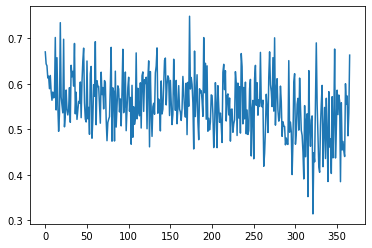

In [32]:
plt.plot(losses[0])

In [33]:
# torch.save(declare.state_dict(), 'demo_model')
# declare.load_state_dict(torch.load('demo_model'))

In [34]:
snopes_eval = DeClareEvaluation(declare, test_dataloader, device)
labels, preds = snopes_eval.claim_wise_accuracies()

/Users/johnjoy/information_systems/DeClare/metrics/evaluation.py:34: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:766.)
  indices = (claims == claim).all(dim=1).nonzero().squeeze(-1)


In [35]:
true_claim_indices = np.where(labels==1)
false_claim_indices = np.where(labels==0)

In [36]:
accuracy_score(labels[true_claim_indices], preds[true_claim_indices]>0.5)

0.47572815533980584

In [37]:
accuracy_score(labels[false_claim_indices], preds[false_claim_indices]>0.5)

0.6505681818181818

In [38]:
roc_auc_score(labels, preds)

0.6063410194174758

In [ ]:
potifact_df = pd.read_csv(POLITIFACT_LOC, sep='\t', header=None)

In [ ]:
potifact_df.head()

In [ ]:
snopes_df = pd.read_csv(SNOPES_LOC, sep='\t', header=None)
snopes_df.head()